In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

C:\Users\Ashi peddi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Image Loading, Preprocessing, Gender Information Extraction from Filenames 

In [2]:
for dirname, _, filenames in os.walk('UTKFace'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
UTKFace\100_1_0_20170112213303693.jpg.chip.jpg
UTKFace\100_1_0_20170112215032192.jpg.chip.jpg
UTKFace\100_1_0_20170117195420803.jpg.chip.jpg
UTKFace\100_1_0_20170119212053665.jpg.chip.jpg
UTKFace\100_1_2_20170105174847679.jpg.chip.jpg
UTKFace\100_1_2_20170112213615815.jpg.chip.jpg
UTKFace\100_1_2_20170112222336458.jpg.chip.jpg
UTKFace\101_0_0_20170112213500903.jpg.chip.jpg
UTKFace\101_1_2_20170105174739309.jpg.chip.jpg
UTKFace\103_0_2_20170112213001988.jpg.chip.jpg
UTKFace\105_0_0_20170112213001988.jpg.chip.jpg
UTKFace\105_1_0_20170112213001988.jpg.chip.jpg
UTKFace\105_1_0_20170112213021902.jpg.chip.jpg
UTKFace\105_1_0_20170112213507183.jpg.chip.jpg
UTKFace\105_1_1_20170112213303693.jpg.chip.jpg
UTKFace\10_0_0_20161220222308131.jpg.chip.jpg
UTKFace\10_0_0_20170103200329407.jpg.chip.jpg
UTKFace\10_0_0_

In [3]:
#extracts gender information from the filenames, converts it to binary labels (0 for male, 1 for female), 
#stores both the binary labels in gender_classes 
#original integer values stored in y_gender.
path= 'UTKFace' 
file_list = os.listdir(path) #Go path and list files
print("Number Of İmages: ", len(file_list))
#Gender
gender = [i.split('_')[1] for i in file_list]
gender_labels= ["Male","Female"]

gender_classes = []
y_gender= []
for i in gender:
    i= int(i)
    if i== 0:
        gender_classes.append(0)
    else:
        gender_classes.append(1)
    y_gender.append(i)
    
gender_classes= np.array(gender_classes)
print("gender_classes shape: ",gender_classes.shape) 


Number Of İmages:  23708
gender_classes shape:  (23708,)


# Data Preparation and Train-Test Split

In [4]:
#resized to dimensions (48, 48), and stored as a NumPy array in x_data, 
x_data=[]
for file in file_list:
    img= cv2.imread(path+'/'+file)
    img=cv2.resize(img,(48,48)) # (200,200)--->(48,48)
    x_data.append(img)
x_data= np.array(x_data)
print("x_data shape: ",x_data.shape)

x_data shape:  (23708, 48, 48, 3)


In [5]:
# Split data into training and testing sets
#The gender labels are one-hot encoded for both training and testing sets.
x_train, x_test, y_train_gender, y_test_gender = train_test_split(
    x_data, gender_classes, test_size=0.2, shuffle=True, random_state=42
)

y_train_gender = to_categorical(y_train_gender, num_classes=2)
y_test_gender = to_categorical(y_test_gender, num_classes=2)

# Define input shape
input_shape = x_train.shape[1:]

# Defining VGGNet for Gender

In [7]:
# Create VGG-based model for gender prediction
#VGG16 model is loaded with weights pre-trained on ImageNet, and its layers are added to a Sequential model.
#All layers in the model are set to non-trainable to retain the pre-trained weights.
#Additional layers, including flattened, dense, and dropout layers, are added
# with binary cross-entropy loss, RMSprop optimizer with a learning rate of 1e-3, and accuracy as the evaluation metric.
from keras.applications.vgg16 import VGG16 
def create_gender_model(input_shape):
    model = Sequential()
    vgg = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

    for layer in vgg.layers:
        model.add(layer)

    for layer in model.layers:
        layer.trainable = False

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(2, activation="sigmoid"))

    return model

# Create and compile gender model
gender_model = create_gender_model(input_shape)
gender_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=["accuracy"]
)

C:\Users\Ashi peddi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
history_gender = gender_model.fit(
    x_train, y_train_gender,
    validation_data=(x_test, y_test_gender),
    epochs=2,
    batch_size=64
)

# Save the trained gender model
gender_model.save('gender_model.h5')


Epoch 1/2
297/297 [==============================] - 113s 373ms/step - loss: 0.6439 - accuracy: 0.7048 - val_loss: 0.5027 - val_accuracy: 0.7588
Epoch 2/2
297/297 [==============================] - 110s 371ms/step - loss: 0.5160 - accuracy: 0.7521 - val_loss: 0.5211 - val_accuracy: 0.7769


In [10]:
# Function to categorize ages into groups
def age_group(age):
    if age >= 0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

In [11]:
# Extract age information from filenames
ages = [int(i.split('_')[0]) for i in file_list]

# Categorize ages into groups
age_classes = [age_group(age) for age in ages]

# Resize images to dimensions (64, 64) and store as a NumPy array
x_data_age = []
for file in file_list:
    img = cv2.imread(path + '/' + file)
    img = cv2.resize(img, (64, 64))
    x_data_age.append(img)

x_data_age = np.array(x_data_age)


In [12]:
# Split data into training and testing sets for age
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(
    x_data_age, age_classes, test_size=0.2, shuffle=True, random_state=42
)

# One-hot encode age labels
y_train_age = to_categorical(y_train_age, num_classes=5)
y_test_age = to_categorical(y_test_age, num_classes=5)

# Define input shape for age model
input_shape_age = x_train_age.shape[1:]

# Defining VGGNet for Age

In [17]:
# Create VGG-based model for age prediction
def create_age_model(input_shape_age):
    model = Sequential()
    vgg_age = VGG16(include_top=False, weights="imagenet", input_shape=input_shape_age)

    for layer in vgg_age.layers:
        model.add(layer)

    for layer in model.layers:
        layer.trainable = False

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(5, activation="relu"))

    return model

# Create and compile age model
age_model = create_age_model(input_shape_age)
age_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=["accuracy"]
)

In [18]:
# Train age model
history_age = age_model.fit(
    x_train_age, y_train_age,
    validation_data=(x_test_age, y_test_age),
    epochs=2,
    batch_size=64
)

# Save the trained age model
age_model.save('age_model.h5')

Epoch 1/2
297/297 [==============================] - 197s 662ms/step - loss: 1.3355 - accuracy: 0.6283 - val_loss: 1.2414 - val_accuracy: 0.6769
Epoch 2/2
297/297 [==============================] - 191s 643ms/step - loss: 1.2187 - accuracy: 0.6721 - val_loss: 1.2310 - val_accuracy: 0.6641


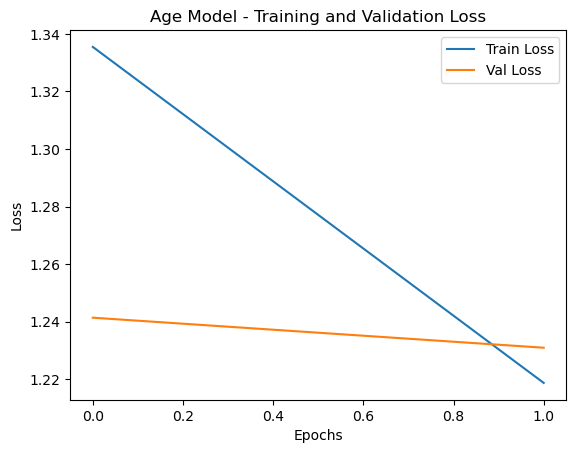

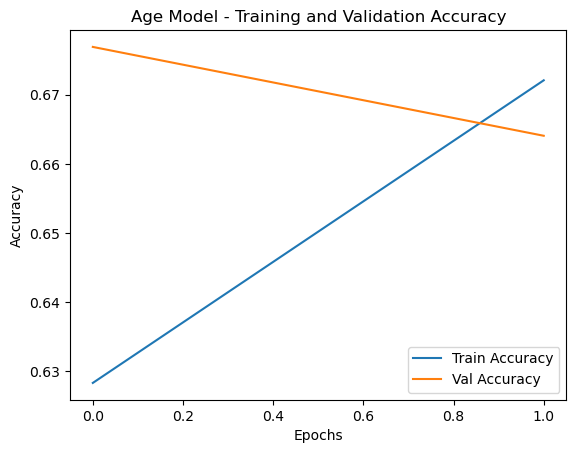

149/149 [==============================] - 39s 265ms/step - loss: 1.2310 - accuracy: 0.6641
Age Model Evaluation - Loss: 1.2309585809707642
Age Model Evaluation - Accuracy: 0.6640657782554626


In [19]:
# Visualize training and validation loss for age model
plt.plot(history_age.history['loss'], label='Train Loss')
plt.plot(history_age.history['val_loss'], label='Val Loss')
plt.title('Age Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy for age model
plt.plot(history_age.history['accuracy'], label='Train Accuracy')
plt.plot(history_age.history['val_accuracy'], label='Val Accuracy')
plt.title('Age Model - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the age model on the test set
age_evaluation = age_model.evaluate(x_test_age, y_test_age)
print("Age Model Evaluation - Loss:", age_evaluation[0])
print("Age Model Evaluation - Accuracy:", age_evaluation[1])


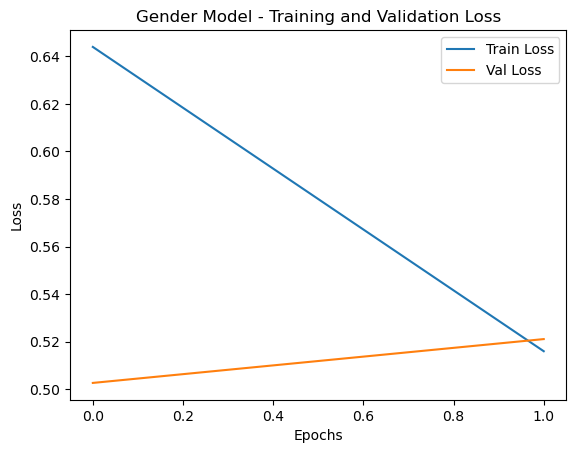

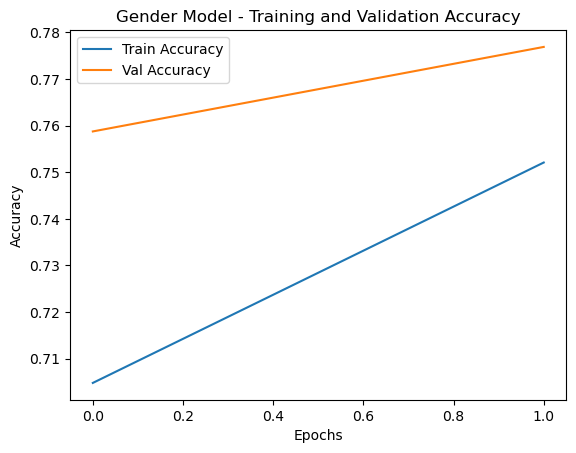

149/149 [==============================] - 23s 155ms/step - loss: 0.5211 - accuracy: 0.7769
Gender Model Evaluation - Loss: 0.5211225152015686
Gender Model Evaluation - Accuracy: 0.7768874168395996


In [20]:
# Visualize training and validation loss for gender model
plt.plot(history_gender.history['loss'], label='Train Loss')
plt.plot(history_gender.history['val_loss'], label='Val Loss')
plt.title('Gender Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy for gender model
plt.plot(history_gender.history['accuracy'], label='Train Accuracy')
plt.plot(history_gender.history['val_accuracy'], label='Val Accuracy')
plt.title('Gender Model - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the gender model on the test set
gender_evaluation = gender_model.evaluate(x_test, y_test_gender)
print("Gender Model Evaluation - Loss:", gender_evaluation[0])
print("Gender Model Evaluation - Accuracy:", gender_evaluation[1])